In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage.morphology import erosion, dilation, opening, closing, disk
from sklearn.cluster import KMeans

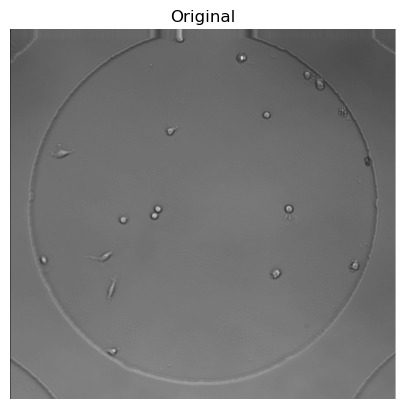

In [2]:
image = cv2.imread('hucre.png',0)

plt.imshow(image, cmap='gray')
plt.title("Original")
plt.axis("off")
plt.show()

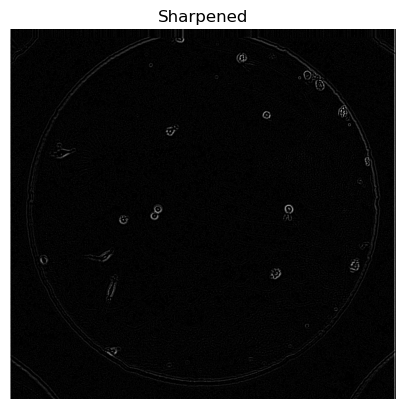

In [3]:
src = cv2.GaussianBlur(image, (5, 5), 1)
dst = cv2.Laplacian(src, cv2.CV_8U, 3, 3, 3)
sharpened = cv2.convertScaleAbs(dst)


plt.imshow(sharpened, cmap='gray')
plt.title("Sharpened")
plt.axis("off")
plt.show()

Threshold:  84.0


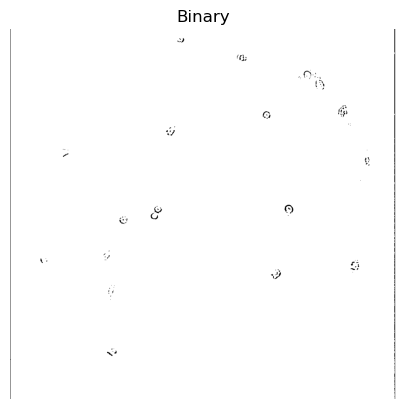

In [4]:
ret, binary_image = cv2.threshold(sharpened, 0, 255, cv2.THRESH_BINARY_INV +  cv2.THRESH_OTSU)

print("Threshold: ", ret)

plt.imshow(binary_image, cmap='gray')
plt.title("Binary")
plt.axis("off")
plt.show()

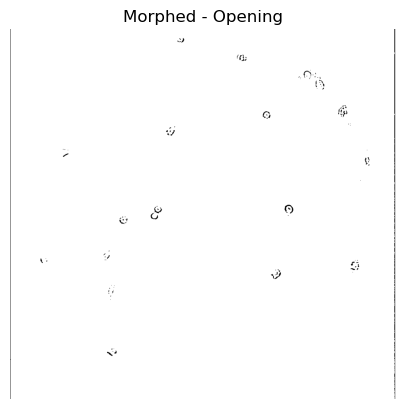

In [5]:
footprint = disk(1)

morph = opening(binary_image, footprint)

plt.imshow(morph, cmap='gray')
plt.title("Morphed - Opening")
plt.axis("off")
plt.show()

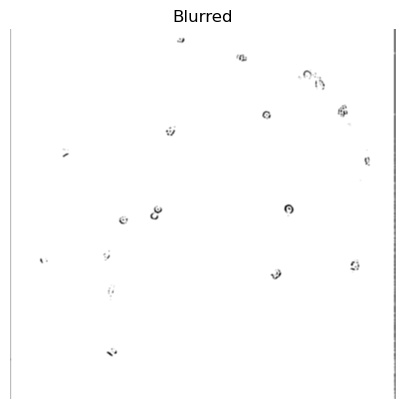

In [6]:
blurred = cv2.GaussianBlur(morph, (5, 5), 3)

plt.imshow(blurred, cmap='gray')
plt.title("Blurred")
plt.axis("off")
plt.show()

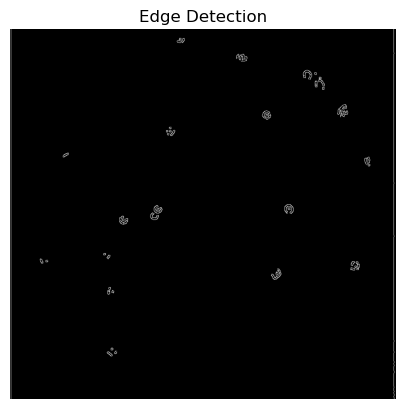

In [7]:
edges = cv2.Canny(blurred,100,200)

plt.imshow(edges, cmap='gray')
plt.title("Edge Detection")
plt.axis("off")
plt.show()

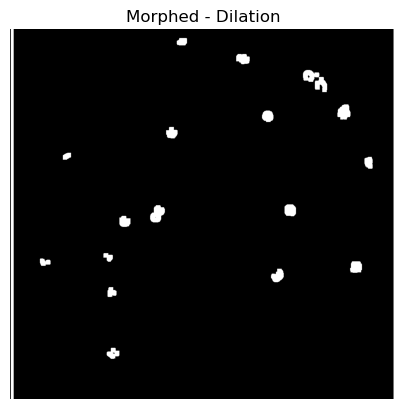

In [8]:
# kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
kernel = np.ones((2,2), np.uint8)

dilated = cv2.dilate(edges, kernel, iterations=6)

plt.imshow(dilated, cmap='gray')
plt.title("Morphed - Dilation")
plt.axis("off")
plt.show()

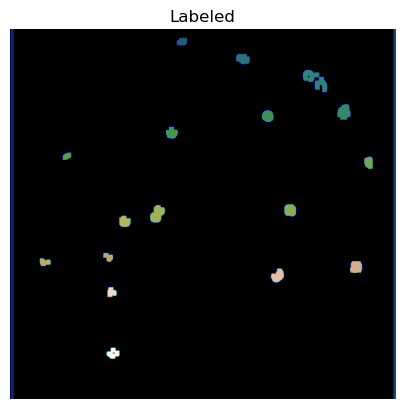

In [9]:
total_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(dilated, connectivity=8, ltype=cv2.CV_32S)


labels[labels == 0] = -1

centroids = centroids[1:]
sizes = stats[1:, -1]
total_labels = total_labels - 1

plt.imshow(labels, cmap='gist_earth')
plt.title("Labeled")
plt.axis("off")
plt.show()

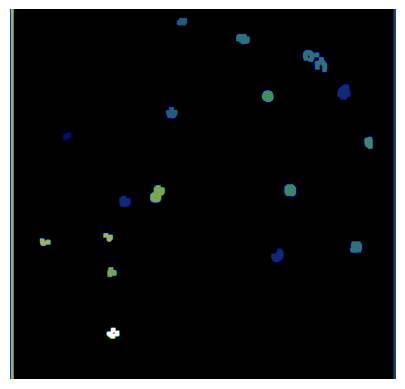

In [10]:
n_clusters = total_labels

kmeans = KMeans(n_clusters=n_clusters, n_init=10).fit(centroids)

labels_clustered = kmeans.labels_

for i in range(len(centroids)):
    labels[labels == i] = labels_clustered[i]

plt.imshow(labels, cmap='gist_earth')
plt.axis("off")
plt.show()

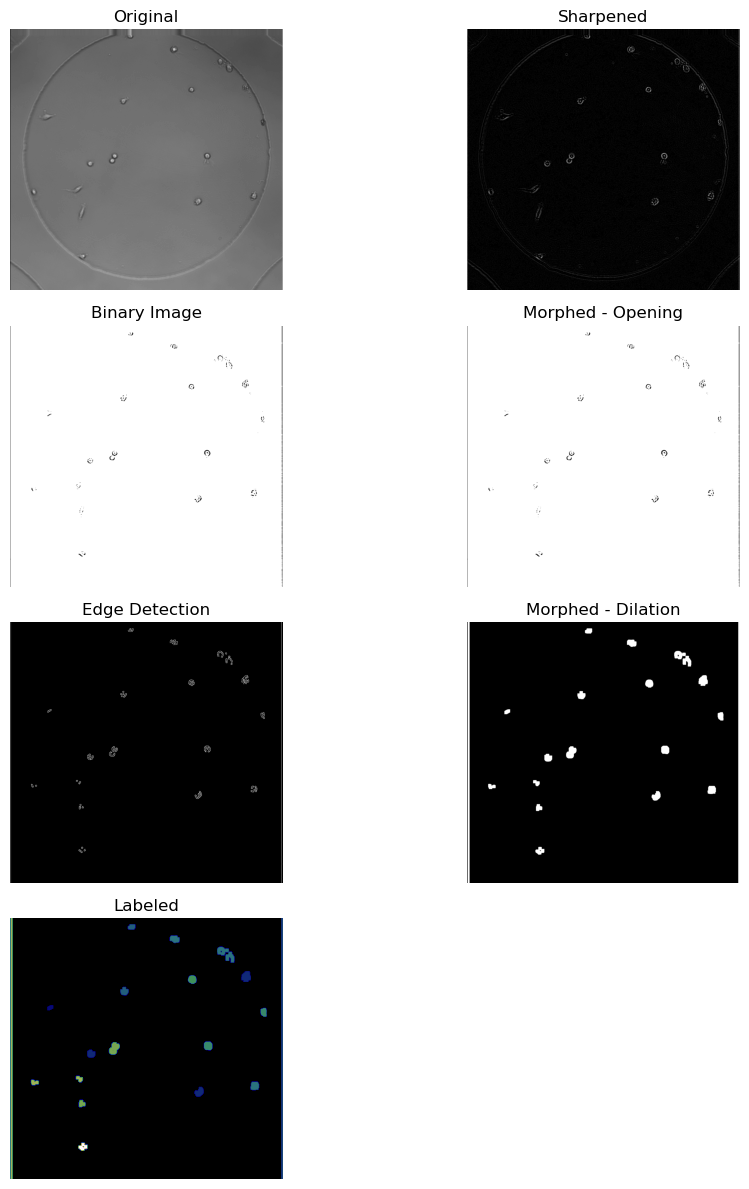

In [11]:
fig, ((ax_original, ax_sharpened), (ax_binary, ax_opened), (ax_edge, ax_dilated), (ax_labeled, ax_)) = plt.subplots(4, 2, figsize=(10, 12))

ax_original.imshow(image, cmap=plt.cm.gray)
ax_original.set_title('Original', fontsize=12)
ax_original.axis("off")

ax_sharpened.imshow(sharpened, cmap=plt.cm.gray)
ax_sharpened.set_title('Sharpened', fontsize=12)
ax_sharpened.axis("off")

ax_binary.imshow(binary_image, cmap=plt.cm.gray)
ax_binary.set_title(f'Binary Image', fontsize=12)
ax_binary.axis("off")

ax_opened.imshow(morph, cmap=plt.cm.gray)
ax_opened.set_title("Morphed - Opening", fontsize=12)
ax_opened.axis("off")


ax_edge.imshow(edges, cmap=plt.cm.gray)
ax_edge.set_title("Edge Detection", fontsize=12)
ax_edge.axis("off")


ax_dilated.imshow(dilated, cmap=plt.cm.gray)
ax_dilated.set_title("Morphed - Dilation", fontsize=12)
ax_dilated.axis("off")

ax_labeled.imshow(labels, cmap='gist_earth')
ax_labeled.set_title("Labeled", fontsize=12)
ax_labeled.axis("off")

fig.delaxes(ax_)

plt.tight_layout()
plt.show()

In [12]:
cx = np.zeros(total_labels)
cy = np.zeros(total_labels)
area = np.zeros(total_labels)
perimeter = np.zeros(total_labels, dtype=int)
aspect_ratio = np.zeros(total_labels)
equi_diameter = np.zeros(total_labels)


properties = np.zeros((total_labels, 3))

for i in range(0, total_labels):
    img2 = np.zeros((labels.shape), dtype=np.uint8)
    img2[labels == i] = 255

    contours, _ = cv2.findContours(img2, 1, 2)

    if contours:
        cnt = contours[0]
        # Area
        area = cv2.contourArea(cnt)
        properties[i, 0] = area  # Store area

        if len(cnt) >= 5:  
            (x, y), (MA, ma), angle = cv2.fitEllipse(cnt)
            properties[i, 1] = angle

        perimeter = cv2.arcLength(cnt, True)
        if perimeter > 0:  
            circularity = 4 * np.pi * area / (perimeter ** 2)
            properties[i, 2] = circularity

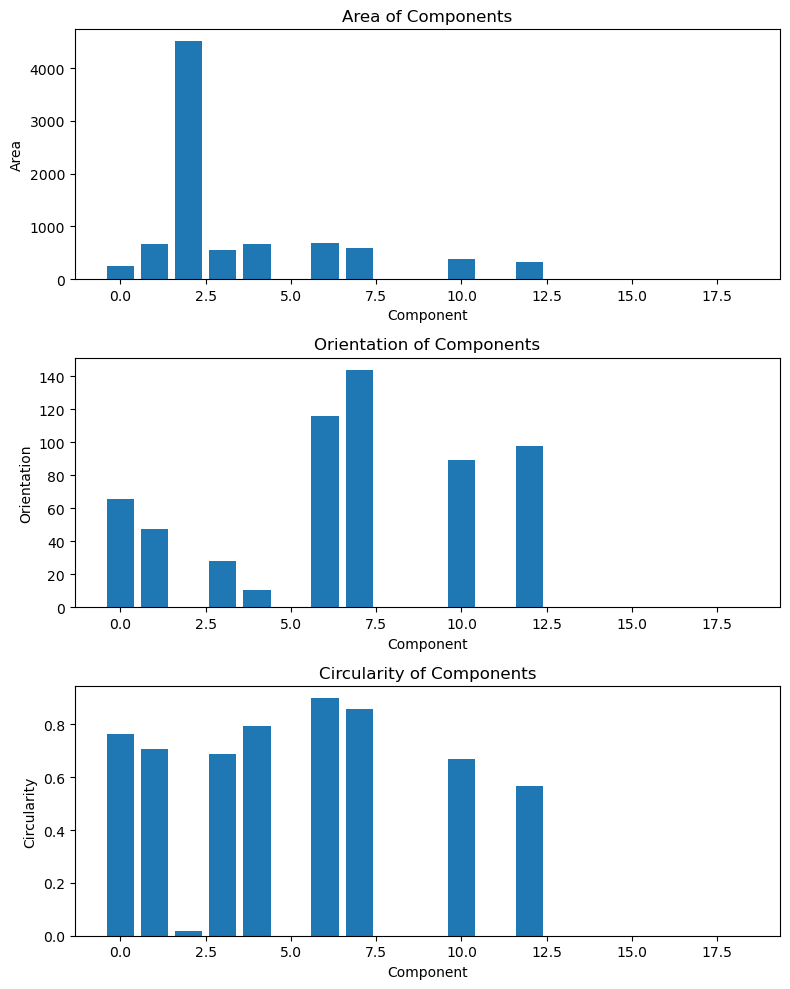

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 10))

ax1.bar(range(total_labels), properties[:, 0])
ax1.set_xlabel('Component')
ax1.set_ylabel('Area')
ax1.set_title('Area of Components')

ax2.bar(range(total_labels), properties[:, 1])
ax2.set_xlabel('Component')
ax2.set_ylabel('Orientation')
ax2.set_title('Orientation of Components')

ax3.bar(range(total_labels), properties[:, 2])
ax3.set_xlabel('Component')
ax3.set_ylabel('Circularity')
ax3.set_title('Circularity of Components')

plt.tight_layout()

plt.show()

In [14]:
labels = cv2.convertScaleAbs(labels)
edges_new = cv2.Canny(labels, 100, 200)
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

ratios = []
compactness_values = []

for i, cnt in enumerate(contours):
    area = cv2.contourArea(cnt)
    perimeter = cv2.arcLength(cnt, True)
    if perimeter > 0 and area > 0:  
        area_perimeter_ratio = area / perimeter
        compactness = (4 * np.pi * area) / (perimeter ** 2)  
    else:
        area_perimeter_ratio = 0
        compactness = 0

    ratios.append(area_perimeter_ratio)
    compactness_values.append(compactness)

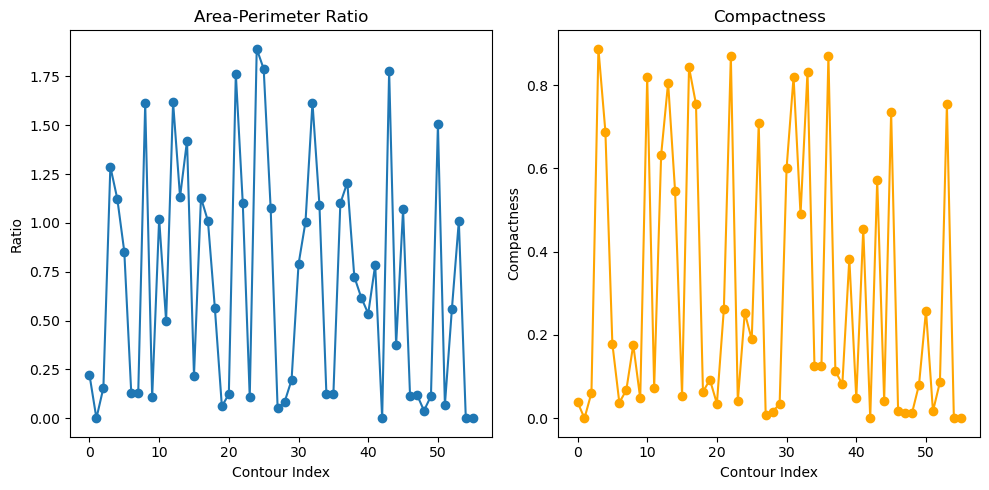

In [15]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(ratios, marker='o')
plt.title('Area-Perimeter Ratio')
plt.xlabel('Contour Index')
plt.ylabel('Ratio')

plt.subplot(1, 2, 2)
plt.plot(compactness_values, marker='o', color='orange')
plt.title('Compactness')
plt.xlabel('Contour Index')
plt.ylabel('Compactness')

plt.tight_layout()
plt.show()